<a href="https://colab.research.google.com/github/darshandesai1095/plant-pathology-ml/blob/main/Plant_Pathology_2020_FGVC7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
#' ' means CPU whereas '/device:G:0' means GPU
print(tf.test.gpu_device_name())
print(tf.__version__)
from tensorflow.keras.layers import (Conv2D, Activation, BatchNormalization, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense)
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
train_path = "/content/gdrive/My Drive/Plant Pathology 2020 - FGVC7/Train_Val_500px/Train"
val_path = "/content/gdrive/My Drive/Plant Pathology 2020 - FGVC7/Train_Val_500px/Val"

In [ ]:
# use image data generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

a, b = 175, 175
image_size = (a,b)
batch_size = 8

train_datagen = ImageDataGenerator(rescale = 1./225,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(rescale = 1./225)

# training data
training_set = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical")

# validation data
validation_set = val_datagen.flow_from_directory(
    directory = val_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical")


Using TensorFlow backend.


Found 1548 images belonging to 4 classes.
Found 273 images belonging to 4 classes.


**NEURAL NETWORK**

**CNN WITH SKIP CONNECTIONS**

In [ ]:
inputs = tf.keras.Input(shape = (a,b,3))
x = inputs

x = Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
x = Dropout(rate=0.3)(x)

x1 = x

x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
x = Dropout(rate=0.3)(x)

x2 = x

x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
x = Dropout(rate=0.3)(x)

x3 = x

x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
x = Dropout(rate=0.3)(x)

x = tf.keras.layers.concatenate([x,x1], axis=-1)

x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)

x = tf.keras.layers.concatenate([x,x1,x2], axis=-1)

x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)

x = tf.keras.layers.concatenate([x,x1,x2,x3], axis=-1)

x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1))(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=1, padding='valid')(x)

x = Flatten()(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)

x = Dense(16)(x)
x = Activation('relu')(x)
outputs = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=0.001)

In [ ]:

'''
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

def train_model():
  
  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()
'''

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    steps_per_epoch = 1548//batch_size,
    epochs = 100,
    verbose = 1,
    validation_steps=273//batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/100
193/193 [==============================] - 781s 4s/step - loss: 1.3404 - accuracy: 0.3446 - val_loss: 1.3780 - val_accuracy: 0.3382 - lr: 0.0100
Epoch 2/100
166/193 [========================>.....] - ETA: 1:11 - loss: 1.3166 - accuracy: 0.3852

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

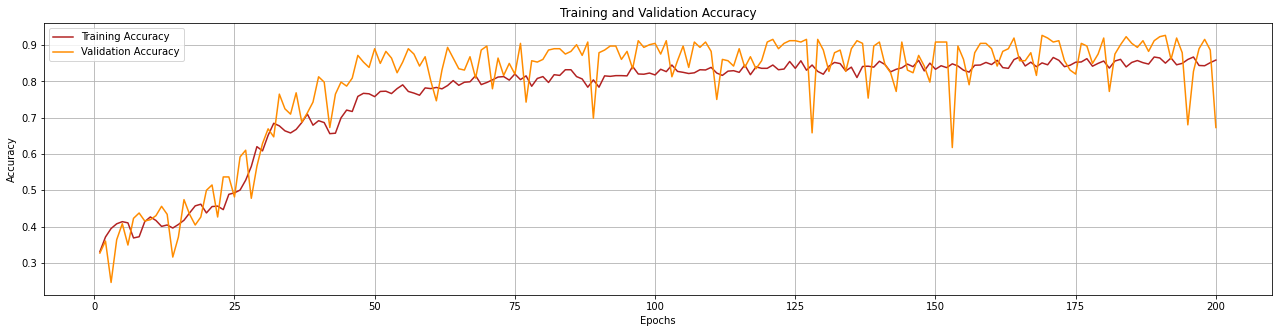

In [ ]:
plt.figure(figsize=(22,5))
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,201)
plt.plot(epochs, train_acc, 'firebrick', label='Training Accuracy')
plt.plot(epochs, val_acc, 'darkorange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(which='major')
plt.show()
#plt.savefig

In [ ]:
history_cont = model.fit(
    training_set,
    validation_data=validation_set,
    steps_per_epoch = 1548//batch_size,
    epochs = 2,
    verbose = 1,
    validation_steps=273//batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/2
193/193 [==============================] - 97s 503ms/step - loss: 0.8932 - accuracy: 0.8487 - val_loss: 0.8639 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 2/2
193/193 [==============================] - 97s 503ms/step - loss: 0.8881 - accuracy: 0.8552 - val_loss: 0.8257 - val_accuracy: 0.9191 - lr: 0.0010


In [ ]:
model.save("/content/gdrive/My Drive/Plant Pathology 2020 - FGVC7/model_1.h5")

In [ ]:
new_model = tf.keras.models.load_model("/content/gdrive/My Drive/Plant Pathology 2020 - FGVC7/model_1.h5")

In [ ]:
history_cont = new_model.fit(
    training_set,
    validation_data=validation_set,
    steps_per_epoch = 1548//batch_size,
    epochs = 5,
    verbose = 1,
    validation_steps=273//batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/5
193/193 [==============================] - 97s 503ms/step - loss: 0.8944 - accuracy: 0.8487 - val_loss: 0.8231 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 2/5
193/193 [==============================] - 97s 503ms/step - loss: 0.8733 - accuracy: 0.8688 - val_loss: 0.8655 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/5
193/193 [==============================] - 97s 504ms/step - loss: 0.8714 - accuracy: 0.8727 - val_loss: 0.8452 - val_accuracy: 0.8971 - lr: 0.0010
Epoch 4/5
193/193 [==============================] - 97s 503ms/step - loss: 0.8784 - accuracy: 0.8656 - val_loss: 1.3139 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 5/5
193/193 [==============================] - 97s 503ms/step - loss: 0.8869 - accuracy: 0.8552 - val_loss: 0.8204 - val_accuracy: 0.9228 - lr: 0.0010


**Inception-V3**



In [ ]:
#By specifying the include_top=False argument, you load a network that doesn’t include the classification layers.
Xception_MODEL = tf.keras.applications.Xception(input_shape = (a,b,3),
                                                       include_top = False,
                                                       weights = 'imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
Xception_MODEL.trainable=True

In [ ]:
inputs = tf.keras.Input(shape = (a,b,3))

x = inputs
x = Xception_MODEL(x)
x = AveragePooling2D(pool_size=(2,2), strides=1, padding='same')(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation='softmax')(x)

In [ ]:
xception_mod = Model(inputs=inputs, outputs=outputs)
xception_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
xception_mod.summary()

In [ ]:
tf.keras.utils.plot_model(xception_mod)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=0.001)

In [ ]:
history = xception_mod.fit(
    training_set,
    validation_data=validation_set,
    steps_per_epoch = 1570//batch_size,
    epochs = 100,
    verbose = 1,
    validation_steps=261//batch_size,
    callbacks=[reduce_lr]
)

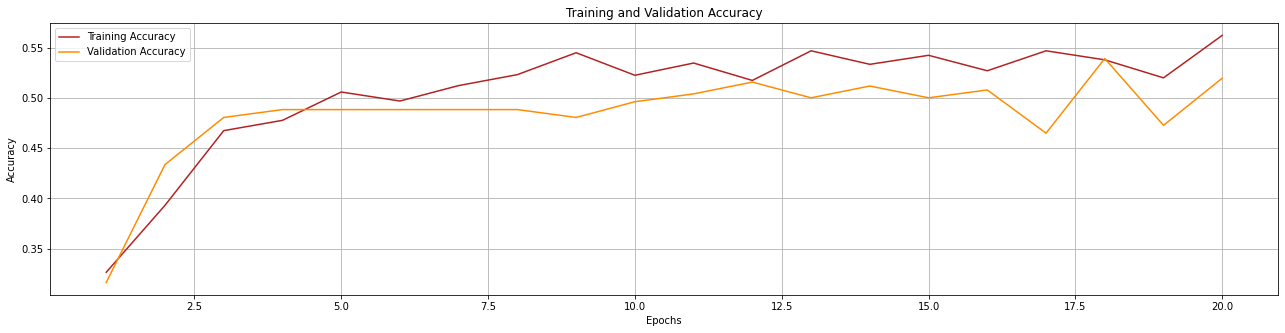

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(22,5))
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, train_acc, 'firebrick', label='Training Accuracy')
plt.plot(epochs, val_acc, 'darkorange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(which='major')
plt.show()
#plt.savefig